# Homecourt Advantage Series Simulator

In [55]:
import numpy as np

## Simulator Functions

The question I wanted to answer was whether a home team had better odds of winning a playoff series under the 2-3-3 or 2-2-1-1-1 formats under the assumption that we know their win probability at home and on the road, and that the games are independent (don't take into account injuries, travel, etc.) I answer this quesiton through simulation.

In [56]:
def sim_game(probs,loc):
    """
    probs = {'h': P(team 1 wins at home), 'a': P(team 1 wins away)}
    loc = home 'h', or away 'a'
    returns 0 if team 1 loses in the sim, 1 if team 1 wins the sim
    """
    return np.random.choice([0,1],1,p=[1-probs[loc],probs[loc]])

In [57]:
def sim_series(home_win,away_win,form):
    """
    home_win = P(team 1 wins at home)
    away_win = P(team 1 wins away)
    form = 0 --> (2-3-2) or 1 --> (2-2-1-1-1)
    returns: 1 if team 1 wins the series, 0 otherwise
    """
    probs = {'h':home_win,'a':away_win}
    
    if form == 0:
        games = ['h','h','a','a','a','h','h']
    elif form == 1:
        games = ['h','h','a','a','h','a','h']
    
    series_score = []
    i = 0
    
    while series_score.count(1)<4 and series_score.count(0)<4:
        series_score.append(sim_game(probs,games[i]))
        i += 1
        
    if series_score.count(1) ==4:
        return 1
    else:
        return 0

With these functions we can simulate each series as Bernouilli trial with unknown $p$. To estimate this $p$ we can take the mean of $n$ simulations for large $n$. The following function does just that.

In [58]:
def sim_n_series(home_win,away_win,form,n = 100):
    """
    home_win = P(team 1 wins at home)
    away_win = P(team 1 wins away)
    form = 0 --> (2-3-2) or 1 --> (2-2-1-1-1)
    n = number of simulations
    returns: percentage of sims won by team 1
    """
    win_count = []
    for i in range(n):
        win_count.append(sim_series(home_win,away_win,form))
    return np.mean(win_count)

## Analysis

To esimate $p$ we compute the percent of series won in 1000 simulations of the 2-3-2 format and the 2-2-1-1-1 format. This is a good predictor of the true probability of winning the series. 

In [59]:
sim_n_series(0.7,0.4,0,1000)

0.65200000000000002

In [60]:
sim_n_series(0.7,0.4,1,1000)

0.64200000000000002

We see that these values are pretty close to each other. After some thought it seems likely that the true probability of winning the series is the same for either format. To verify this we can take advantage of the central limit theorem. If the two formats truly had the same $p$ value we would expect the distributions of these  percents (which are means) to approach the same normal curve after many simulations. Thus we take 10,000 simulations of size 100 and plot their distributions. If they look the same we can be prety confident that the true probabilities are the same.

This process takes a few minutes to run so we will also make a helper function to save our results so we don't need to re-simulate everytime we run this notebook.

In [68]:
def list_to_csv(lst,file_name):
    with open(file_name, "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        writer.writerow(['values'])  
        for val in lst:
            writer.writerow([val])  

In [83]:
import pandas as pd
try:
    sims1_df = pd.read_csv('sims1.csv')
    sims2_df = pd.read_csv('sims2.csv')
    print('Using cached version')
    sims1 = sims1_df.iloc[:]
    sims2 = sims2_df.iloc[:]
except FileNotFoundError as e:
    print('Simulating...')
    sims1 = [sim_n_series(0.7,0.4,0,100) for i in range(10000)]
    sims2 = [sim_n_series(0.7,0.4,1,100) for i in range(10000)]
    list_to_csv(sims1,'sims1.csv')
    list_to_csv(sims2,'sims2.csv')
    print('Done!')

Using cached version


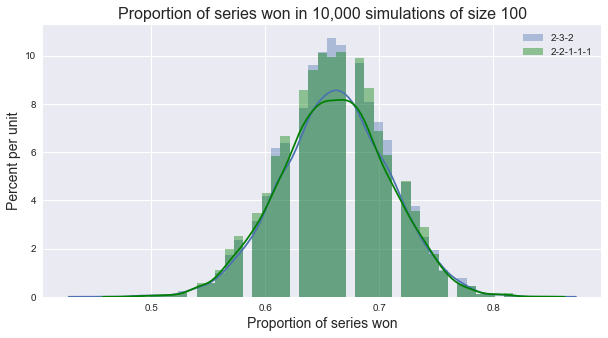

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

bins = np.linspace(0.45,0.85,50)

sns.set(rc={'figure.figsize':(10,5)})

ax = sns.distplot(sims1,label='2-3-2',bins=bins)
sns.distplot(sims2,label='2-2-1-1-1',color='Green',bins=bins)
plt.title("Proportion of series won in 10,000 simulations of size 100",fontsize=16)
plt.xlabel('Proportion of series won',fontsize=14)
plt.ylabel('Percent per unit',fontsize=14)
plt.legend()

In [71]:
print(np.mean(sims1),np.mean(sims2))

0.661428 0.660378


Based on the plot above we can be confident that the two distributions are the same and the true $p$ is approximated by the mean of either distribution, which is approximately 66%.

## Modification: Win in $\leq$ 5 Games

We are also asked whether the question changes when Team 1 wants to win in 5 games or fewer. Thus we ask ourselves what is the probability that Team 1 wins the series in 5 or fewer games when the series format is 2-3-2 versus 2-2-1-1-1. We can compute this in the same way as before by making some small modifications to the "sim_series" and "sim_n_series" functions.

In [72]:
def sim_series_5(home_win,away_win,form):
    """
    home_win = P(team 1 wins at home)
    away_win = P(team 1 wins away)
    form = 0 --> (2-3-2) or 1 --> (2-2-1-1-1)
    returns: 1 if team 1 wins the series, 0 otherwise
    """
    probs = {'h':home_win,'a':away_win}
    
    if form == 0:
        games = ['h','h','a','a','a','h','h']
    elif form == 1:
        games = ['h','h','a','a','h','a','h']
    
    series_score = []
    i = 0
    
    #Modify this while condition, to make sure total games <=  5
    while series_score.count(1)<4 and series_score.count(0)<4 and i<5:
        series_score.append(sim_game(probs,games[i]))
        i += 1
        
    if series_score.count(1) ==4:
        return 1
    else:
        return 0

In [73]:
def sim_n_series_5(home_win,away_win,form,n = 100):
    """
    home_win = P(team 1 wins at home)
    away_win = P(team 1 wins away)
    form = 0 --> (2-3-2) or 1 --> (2-2-1-1-1)
    n = number of simulations
    returns: percentage of sims won by team 1
    """
    win_count = []
    for i in range(n):
        #Call sim_series_5 instead of sim_series
        win_count.append(sim_series_5(home_win,away_win,form))
    return np.mean(win_count)

In [74]:
sim_n_series_5(0.7,0.4,0,1000)

0.185

In [76]:
sim_n_series_5(0.7,0.4,1,1000)

0.28399999999999997

We notice a much more pronounced difference in the winning % here than when we did not care about the number of games. As before let's simulate lots of size 100 simulations and plot the distributions to see if this might be due to chance. As before we try to used a cached simulation to avoid recomputing.

In [82]:
import pandas as pd
try:
    sims3_df = pd.read_csv('sims3.csv')
    sims4_df = pd.read_csv('sims4.csv')
    print('Using cached version')
    sims3 = sims3_df.iloc[:]
    sims4 = sims4_df.iloc[:]
except FileNotFoundError as e:
    print('Simulating...')
    sims3 = [sim_n_series_5(0.7,0.4,0,100) for i in range(10000)]
    sims4 = [sim_n_series_5(0.7,0.4,1,100) for i in range(10000)]
    list_to_csv(sims3,'sims3.csv')
    list_to_csv(sims4,'sims4.csv')
    print('Done!')

Using cached version


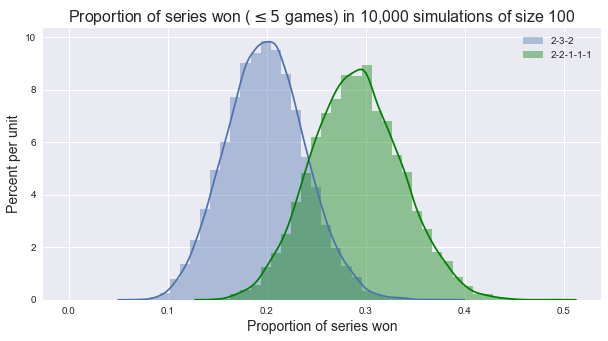

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

bins = np.linspace(0,0.5,50)

sns.set(rc={'figure.figsize':(10,5)})

ax = sns.distplot(sims3,label='2-3-2',bins=bins)
sns.distplot(sims4,label='2-2-1-1-1',color='Green',bins=bins)
plt.title("Proportion of series won ($\leq 5$ games) in 10,000 simulations of size 100",fontsize=16)
plt.xlabel('Proportion of series won',fontsize=14)
plt.ylabel('Percent per unit',fontsize=14)
plt.legend()

In [81]:
print(np.mean(sims3),np.mean(sims4))

0.199191 0.290637
